In [1]:
import os
import pickle

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_dir = '../data'
results_dir = '../results'
task = 'by_timepoint'

task_data_dir = data_dir
task_results_dir = os.path.join(results_dir, task)

if not os.path.exists(task_results_dir):
    os.makedirs(task_results_dir)

In [3]:
# Set a random seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define the MLP model
class DeepMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DeepMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu2(x)
        x = self.fc2(x)
        return x

# Function to calculate accuracy
def calculate_mae(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    _, actual = torch.max(labels, 1)
    # mean absolute error
    correct = (predicted - actual).abs().sum().item()
    return correct / labels.size(0)

def train_mlp(input_data, labels, val_data, val_labels, hidden_size=10, learning_rate=0.01, epochs=100, seed=42, gpu_device=None, l2_lambda=0.01, depth="shallow", print_step=100):
    # Set the seed for reproducibility
    set_seed(seed)

    # Set device to the specified GPU if available, otherwise CPU
    if gpu_device is not None and torch.cuda.is_available():
        device = torch.device(f"cuda:{gpu_device}")
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"Using device: {device}")

    input_size = input_data.shape[1]
    output_size = labels.shape[1]

    # Initialize the model, loss function, and optimizer
    if depth == "shallow":
        model = MLP(input_size, hidden_size, output_size).to(device)
    elif depth == "deep":
        model = DeepMLP(input_size, hidden_size, output_size).to(device)
    else:
        raise Exception("Error in model depth provided.")
    
    criterion = nn.MSELoss()  # Assuming we're doing regression, adjust for classification if needed
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)  # L2 regularization added via weight_decay

    # Convert input data and validation data to PyTorch tensors and move to device
    input_tensor = torch.FloatTensor(input_data).to(device)
    labels_tensor = torch.FloatTensor(labels).to(device)
    val_tensor = torch.FloatTensor(val_data).to(device)
    val_labels_tensor = torch.FloatTensor(val_labels).to(device)

    # Lists to store training and validation losses
    training_losses = []
    validation_losses = []
    training_accuracies = []
    validation_accuracies = []

    # Training loop
    for epoch in range(epochs):
        # Forward pass on training data
        model.train()
        outputs = model(input_tensor)
        loss = criterion(outputs, labels_tensor)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store training loss
        training_losses.append(loss.item())

        # Calculate training accuracy
        train_mae = calculate_mae(outputs, labels_tensor)
        training_accuracies.append(train_mae)

        # Evaluate on the validation set
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            val_outputs = model(val_tensor)
            val_loss = criterion(val_outputs, val_labels_tensor)

        # Store validation loss
        validation_losses.append(val_loss.item())

        # Calculate validation accuracy
        val_mae = calculate_mae(val_outputs, val_labels_tensor)
        validation_accuracies.append(val_mae)

        if (epoch + 1) % print_step == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}')
        
    return {"model": model,
            "training_losses": training_losses,
            "validation_losses": validation_losses,
            "training_acc": training_accuracies,
            "validation_acc": validation_accuracies}

# Function to evaluate the MLP on a test set
def evaluate_mlp(model, test_data, test_labels, device):
    model.eval()
    test_tensor = torch.FloatTensor(test_data).to(device)
    test_labels_tensor = torch.FloatTensor(test_labels).to(device)
    criterion = nn.MSELoss()

    with torch.no_grad():
        test_outputs = model(test_tensor)
        test_loss = criterion(test_outputs, test_labels_tensor)
        test_accuracy = calculate_mae(test_outputs, test_labels_tensor)

    print(f'Test Loss: {test_loss.item():.4f}, Test MAE: {test_accuracy:.4f}')

    return (test_loss.item(), test_accuracy, test_outputs.to('cpu'))

In [4]:
# # Example usage:
# # 2D input vectors and 2D output labels for training
# input_data = np.array([[0.5, 0.3, 0], [0.5, 0.3, 1], [0.9, 0.1, 0], [0.7, 0.6, 0]])
# labels = np.array([[0.5, 0.3], [0.4, 0.7], [0.3, 0.2], [0.6, 0.9]])

# # 2D validation vectors and 2D output labels for validation
# val_data = np.array([[0.4, 0.2, 0], [0.3, 0.9, 1]])
# val_labels = np.array([[0.2, 0.4], [0.5, 0.6]])

# # Train the MLP and track validation loss
# results = train_mlp(input_data, labels, val_data, val_labels, hidden_size=5, learning_rate=0.01, epochs=100, seed=42, gpu_device=3)

In [5]:
def build_data(csv_files):
    inputs_list = list()
    outputs_list = list()

    for file in csv_files:
        df = pd.read_csv(file)
        initial_conditions = np.tile(df[df["Time"]==0][["Prey", "Predator"]].to_numpy()[0], (df.shape[0], 1))
        times = df["Time"].to_numpy().reshape(-1,1)
        inputs_list.append( np.hstack((initial_conditions, times)) )
        outputs_list.append( df[["Prey","Predator"]].to_numpy() )

    inputs = np.vstack(inputs_list)
    outputs = np.vstack(outputs_list)

    return inputs, outputs

data_files = [f for f in os.listdir(task_data_dir) if f.endswith('csv') and f.startswith('predator')]
training_indices = [0,1,2,3]
validation_indices = [4,5,6,7]
testing_indices = [8,9]

# Set up training data
train_csv_files = [os.path.join(task_data_dir, data_files[i]) for i in training_indices]
training_inputs, training_outputs = build_data(train_csv_files)
training_data = {
    'inputs': training_inputs,
    'labels': training_outputs
}
print(training_data['inputs'].shape)

# Set up validaiton data
valid_csv_files = [os.path.join(task_data_dir, data_files[i]) for i in validation_indices]
valid_inputs, valid_outputs = build_data(valid_csv_files)
validation_data = {
    'inputs': valid_inputs,
    'labels': valid_outputs
}
print(validation_data['inputs'].shape)

# Set up testing data
test_csv_files = [os.path.join(task_data_dir, data_files[i]) for i in testing_indices]
test_inputs, test_outputs = build_data(test_csv_files)
testing_data = {
    'inputs': test_inputs,
    'labels': test_outputs
}
print(testing_data['inputs'].shape)

split_string = f"{','.join(map(str,training_indices))}:{','.join(map(str,validation_indices))}:{','.join(map(str,testing_indices))}"
print(split_string)

(4000, 3)
(4000, 3)
(2000, 3)
0,1,2,3:4,5,6,7:8,9


In [6]:
epochs = 1000000
seed = 42
l2_lambda = 0.01
lr = 0.001
hidden_size=100
depth = "deep"
gpu_device = 3
suffix = f"{epochs}-{seed}-{l2_lambda}-{lr}-{hidden_size}-{depth}-{split_string}"

In [7]:
# Train!
results = train_mlp(training_data['inputs'], 
                  training_data['labels'], 
                  validation_data['inputs'], 
                  validation_data['labels'], 
                  hidden_size=hidden_size, 
                  learning_rate=lr, 
                  epochs=epochs, 
                  seed=seed,
                  gpu_device=gpu_device,
                  l2_lambda=l2_lambda,
                  depth=depth,
                  print_step=10000)

# Evaluate the model on the test set
test_loss, test_acc, test_outputs = evaluate_mlp(results["model"], testing_data['inputs'], testing_data['labels'], 
             device=torch.device(f"cuda:{gpu_device}") if torch.cuda.is_available() else torch.device("cpu"))

results['test_loss'] = test_loss
results['test_acc'] = test_acc

# Save the results as a pickled object
with open(os.path.join(task_results_dir, f'mlp_training_results_{suffix}.pkl'), 'wb') as f:
    pickle.dump(results, f)

Using device: cuda:3


Epoch [10000/1000000], Loss: 250.6712, Validation Loss: 1551.8218, Train MAE: 0.1767, Val MAE: 0.4200


Epoch [20000/1000000], Loss: 227.8727, Validation Loss: 2480.5415, Train MAE: 0.1745, Val MAE: 0.4798


Epoch [30000/1000000], Loss: 216.0186, Validation Loss: 3803.1406, Train MAE: 0.1777, Val MAE: 0.4908


Epoch [40000/1000000], Loss: 211.8271, Validation Loss: 4862.2881, Train MAE: 0.1757, Val MAE: 0.4820


Epoch [50000/1000000], Loss: 220.9753, Validation Loss: 5738.3198, Train MAE: 0.1795, Val MAE: 0.4585


Epoch [60000/1000000], Loss: 204.2355, Validation Loss: 6359.5532, Train MAE: 0.1720, Val MAE: 0.4607


Epoch [70000/1000000], Loss: 200.5168, Validation Loss: 6799.4233, Train MAE: 0.1618, Val MAE: 0.4582


Epoch [80000/1000000], Loss: 198.6287, Validation Loss: 6819.4375, Train MAE: 0.1580, Val MAE: 0.4572


Epoch [90000/1000000], Loss: 194.1264, Validation Loss: 7385.8892, Train MAE: 0.1573, Val MAE: 0.4505


Epoch [100000/1000000], Loss: 191.9102, Validation Loss: 7504.1938, Train MAE: 0.1520, Val MAE: 0.4515


Epoch [110000/1000000], Loss: 189.7279, Validation Loss: 7969.9712, Train MAE: 0.1515, Val MAE: 0.4502


Epoch [120000/1000000], Loss: 187.0729, Validation Loss: 8990.7002, Train MAE: 0.1460, Val MAE: 0.4517


Epoch [130000/1000000], Loss: 184.4428, Validation Loss: 10567.3203, Train MAE: 0.1475, Val MAE: 0.4440


Epoch [140000/1000000], Loss: 182.4865, Validation Loss: 12103.0732, Train MAE: 0.1437, Val MAE: 0.4363


Epoch [150000/1000000], Loss: 180.1626, Validation Loss: 13850.1426, Train MAE: 0.1415, Val MAE: 0.4395


Epoch [160000/1000000], Loss: 178.5928, Validation Loss: 15354.8770, Train MAE: 0.1422, Val MAE: 0.4380


Epoch [170000/1000000], Loss: 176.6921, Validation Loss: 16926.0176, Train MAE: 0.1398, Val MAE: 0.4602


Epoch [180000/1000000], Loss: 176.0035, Validation Loss: 18626.2129, Train MAE: 0.1380, Val MAE: 0.4440


Epoch [190000/1000000], Loss: 175.7736, Validation Loss: 20238.8809, Train MAE: 0.1368, Val MAE: 0.4657


Epoch [200000/1000000], Loss: 172.9551, Validation Loss: 21973.2129, Train MAE: 0.1405, Val MAE: 0.4597


Epoch [210000/1000000], Loss: 171.6922, Validation Loss: 22877.1855, Train MAE: 0.1335, Val MAE: 0.4735


Epoch [220000/1000000], Loss: 172.6905, Validation Loss: 24559.7832, Train MAE: 0.1487, Val MAE: 0.4745


Epoch [230000/1000000], Loss: 167.8654, Validation Loss: 25900.6934, Train MAE: 0.1340, Val MAE: 0.4800


Epoch [240000/1000000], Loss: 169.4700, Validation Loss: 27072.8262, Train MAE: 0.1345, Val MAE: 0.4790


Epoch [250000/1000000], Loss: 166.1593, Validation Loss: 28926.2773, Train MAE: 0.1385, Val MAE: 0.4708


Epoch [260000/1000000], Loss: 163.6312, Validation Loss: 29820.1289, Train MAE: 0.1305, Val MAE: 0.4522


Epoch [270000/1000000], Loss: 162.6268, Validation Loss: 31125.0566, Train MAE: 0.1330, Val MAE: 0.4485


Epoch [280000/1000000], Loss: 164.8323, Validation Loss: 31598.4824, Train MAE: 0.1303, Val MAE: 0.4745


Epoch [290000/1000000], Loss: 160.8971, Validation Loss: 32807.7461, Train MAE: 0.1293, Val MAE: 0.4515


Epoch [300000/1000000], Loss: 163.6998, Validation Loss: 33311.8828, Train MAE: 0.1285, Val MAE: 0.4517


Epoch [310000/1000000], Loss: 160.3872, Validation Loss: 34300.3047, Train MAE: 0.1338, Val MAE: 0.4470


Epoch [320000/1000000], Loss: 159.0307, Validation Loss: 35273.3086, Train MAE: 0.1303, Val MAE: 0.4495


Epoch [330000/1000000], Loss: 159.7883, Validation Loss: 36183.8516, Train MAE: 0.1258, Val MAE: 0.4537


Epoch [340000/1000000], Loss: 177.7890, Validation Loss: 38044.1055, Train MAE: 0.1842, Val MAE: 0.4460


Epoch [350000/1000000], Loss: 161.0458, Validation Loss: 37763.5156, Train MAE: 0.1275, Val MAE: 0.4547


Epoch [360000/1000000], Loss: 157.8372, Validation Loss: 38966.6523, Train MAE: 0.1245, Val MAE: 0.4467


Epoch [370000/1000000], Loss: 159.5345, Validation Loss: 40436.4805, Train MAE: 0.1380, Val MAE: 0.4447


Epoch [380000/1000000], Loss: 154.3894, Validation Loss: 40136.7734, Train MAE: 0.1212, Val MAE: 0.4407


Epoch [390000/1000000], Loss: 154.1816, Validation Loss: 39289.8828, Train MAE: 0.1215, Val MAE: 0.4417


Epoch [400000/1000000], Loss: 168.0137, Validation Loss: 39753.0000, Train MAE: 0.1465, Val MAE: 0.4370


Epoch [410000/1000000], Loss: 160.2863, Validation Loss: 38701.2188, Train MAE: 0.1320, Val MAE: 0.4410


Epoch [420000/1000000], Loss: 151.4350, Validation Loss: 38699.4492, Train MAE: 0.1175, Val MAE: 0.4450


Epoch [430000/1000000], Loss: 153.4101, Validation Loss: 38211.4023, Train MAE: 0.1192, Val MAE: 0.4475


Epoch [440000/1000000], Loss: 151.9049, Validation Loss: 38853.7930, Train MAE: 0.1318, Val MAE: 0.4415


Epoch [450000/1000000], Loss: 150.7510, Validation Loss: 38851.7070, Train MAE: 0.1320, Val MAE: 0.4417


Epoch [460000/1000000], Loss: 154.6485, Validation Loss: 39275.5156, Train MAE: 0.1412, Val MAE: 0.4412


Epoch [470000/1000000], Loss: 148.7523, Validation Loss: 39016.8477, Train MAE: 0.1305, Val MAE: 0.4440


Epoch [480000/1000000], Loss: 147.8621, Validation Loss: 39337.5625, Train MAE: 0.1260, Val MAE: 0.4427


Epoch [490000/1000000], Loss: 151.6716, Validation Loss: 39630.0977, Train MAE: 0.1155, Val MAE: 0.4440


Epoch [500000/1000000], Loss: 149.0286, Validation Loss: 39533.2617, Train MAE: 0.1182, Val MAE: 0.4590


Epoch [510000/1000000], Loss: 148.9035, Validation Loss: 40112.1094, Train MAE: 0.1210, Val MAE: 0.4440


Epoch [520000/1000000], Loss: 147.3949, Validation Loss: 40808.8750, Train MAE: 0.1143, Val MAE: 0.4437


Epoch [530000/1000000], Loss: 144.5519, Validation Loss: 42175.2383, Train MAE: 0.1245, Val MAE: 0.4435


Epoch [540000/1000000], Loss: 143.3311, Validation Loss: 43088.0352, Train MAE: 0.1108, Val MAE: 0.4435


Epoch [550000/1000000], Loss: 145.4075, Validation Loss: 43839.4336, Train MAE: 0.1143, Val MAE: 0.4592


Epoch [560000/1000000], Loss: 164.0441, Validation Loss: 44011.9023, Train MAE: 0.1368, Val MAE: 0.4417


Epoch [570000/1000000], Loss: 143.0130, Validation Loss: 47291.2266, Train MAE: 0.1110, Val MAE: 0.4432


Epoch [580000/1000000], Loss: 144.6837, Validation Loss: 49645.4688, Train MAE: 0.1403, Val MAE: 0.4370


Epoch [590000/1000000], Loss: 143.2084, Validation Loss: 51127.2070, Train MAE: 0.1150, Val MAE: 0.4427


Epoch [600000/1000000], Loss: 140.2492, Validation Loss: 53173.5938, Train MAE: 0.1138, Val MAE: 0.4425


Epoch [610000/1000000], Loss: 140.2651, Validation Loss: 54972.7539, Train MAE: 0.1145, Val MAE: 0.4405


Epoch [620000/1000000], Loss: 141.1035, Validation Loss: 56342.9766, Train MAE: 0.1310, Val MAE: 0.4358


Epoch [630000/1000000], Loss: 139.0745, Validation Loss: 58500.6484, Train MAE: 0.1160, Val MAE: 0.4305


Epoch [640000/1000000], Loss: 140.0254, Validation Loss: 59900.5703, Train MAE: 0.1110, Val MAE: 0.4278


Epoch [650000/1000000], Loss: 141.5078, Validation Loss: 61515.8477, Train MAE: 0.1098, Val MAE: 0.4270


Epoch [660000/1000000], Loss: 138.3509, Validation Loss: 62316.3945, Train MAE: 0.1092, Val MAE: 0.4270


Epoch [670000/1000000], Loss: 152.2730, Validation Loss: 62526.5586, Train MAE: 0.1247, Val MAE: 0.4285


Epoch [680000/1000000], Loss: 137.2561, Validation Loss: 64741.3242, Train MAE: 0.1187, Val MAE: 0.4280


Epoch [690000/1000000], Loss: 140.7362, Validation Loss: 65160.1602, Train MAE: 0.1113, Val MAE: 0.4278


Epoch [700000/1000000], Loss: 142.2694, Validation Loss: 66409.4766, Train MAE: 0.1168, Val MAE: 0.4285


Epoch [710000/1000000], Loss: 137.4506, Validation Loss: 67624.2031, Train MAE: 0.1087, Val MAE: 0.4273


Epoch [720000/1000000], Loss: 138.5335, Validation Loss: 69037.5234, Train MAE: 0.1105, Val MAE: 0.4265


Epoch [730000/1000000], Loss: 157.7504, Validation Loss: 72645.8438, Train MAE: 0.1475, Val MAE: 0.4268


Epoch [740000/1000000], Loss: 135.4043, Validation Loss: 72580.0000, Train MAE: 0.1222, Val MAE: 0.4245


Epoch [750000/1000000], Loss: 135.1748, Validation Loss: 74003.1719, Train MAE: 0.1098, Val MAE: 0.4243


Epoch [760000/1000000], Loss: 139.7029, Validation Loss: 76656.7344, Train MAE: 0.1330, Val MAE: 0.4223


Epoch [770000/1000000], Loss: 134.2952, Validation Loss: 77613.2578, Train MAE: 0.1192, Val MAE: 0.4215


Epoch [780000/1000000], Loss: 134.6897, Validation Loss: 80676.8828, Train MAE: 0.1255, Val MAE: 0.4195


Epoch [790000/1000000], Loss: 135.9272, Validation Loss: 83105.2188, Train MAE: 0.1293, Val MAE: 0.4165


Epoch [800000/1000000], Loss: 134.4550, Validation Loss: 83908.3047, Train MAE: 0.1095, Val MAE: 0.4195


Epoch [810000/1000000], Loss: 133.6430, Validation Loss: 85516.3438, Train MAE: 0.1240, Val MAE: 0.4168


Epoch [820000/1000000], Loss: 134.5044, Validation Loss: 86801.6016, Train MAE: 0.1245, Val MAE: 0.4180


Epoch [830000/1000000], Loss: 132.0673, Validation Loss: 87192.3672, Train MAE: 0.1170, Val MAE: 0.4185


Epoch [840000/1000000], Loss: 134.6436, Validation Loss: 87047.1719, Train MAE: 0.1105, Val MAE: 0.4210


Epoch [850000/1000000], Loss: 135.6748, Validation Loss: 89692.3281, Train MAE: 0.1192, Val MAE: 0.4173


Epoch [860000/1000000], Loss: 131.7279, Validation Loss: 90744.6953, Train MAE: 0.1242, Val MAE: 0.4173


Epoch [870000/1000000], Loss: 130.4889, Validation Loss: 91260.2422, Train MAE: 0.1133, Val MAE: 0.4195


Epoch [880000/1000000], Loss: 131.8215, Validation Loss: 91688.8359, Train MAE: 0.1075, Val MAE: 0.4183


Epoch [890000/1000000], Loss: 136.6124, Validation Loss: 94347.2188, Train MAE: 0.1318, Val MAE: 0.4173


Epoch [900000/1000000], Loss: 134.2824, Validation Loss: 92803.3672, Train MAE: 0.1100, Val MAE: 0.4168


Epoch [910000/1000000], Loss: 131.8412, Validation Loss: 94282.5234, Train MAE: 0.1085, Val MAE: 0.4150


Epoch [920000/1000000], Loss: 129.8604, Validation Loss: 95481.9688, Train MAE: 0.1098, Val MAE: 0.4138


Epoch [930000/1000000], Loss: 131.9568, Validation Loss: 96443.0234, Train MAE: 0.1227, Val MAE: 0.4130


Epoch [940000/1000000], Loss: 150.0995, Validation Loss: 98110.6953, Train MAE: 0.1425, Val MAE: 0.4150


Epoch [950000/1000000], Loss: 132.7921, Validation Loss: 95633.2031, Train MAE: 0.1245, Val MAE: 0.4143


Epoch [960000/1000000], Loss: 129.4572, Validation Loss: 95768.0781, Train MAE: 0.1075, Val MAE: 0.4148


Epoch [970000/1000000], Loss: 128.5539, Validation Loss: 98141.6328, Train MAE: 0.1098, Val MAE: 0.4145


Epoch [980000/1000000], Loss: 128.0807, Validation Loss: 97522.5312, Train MAE: 0.1082, Val MAE: 0.4145


Epoch [990000/1000000], Loss: 127.5575, Validation Loss: 98905.0781, Train MAE: 0.1187, Val MAE: 0.4143


Epoch [1000000/1000000], Loss: 126.9410, Validation Loss: 100182.1953, Train MAE: 0.1163, Val MAE: 0.4168
Test Loss: 79962.3594, Test MAE: 0.4700


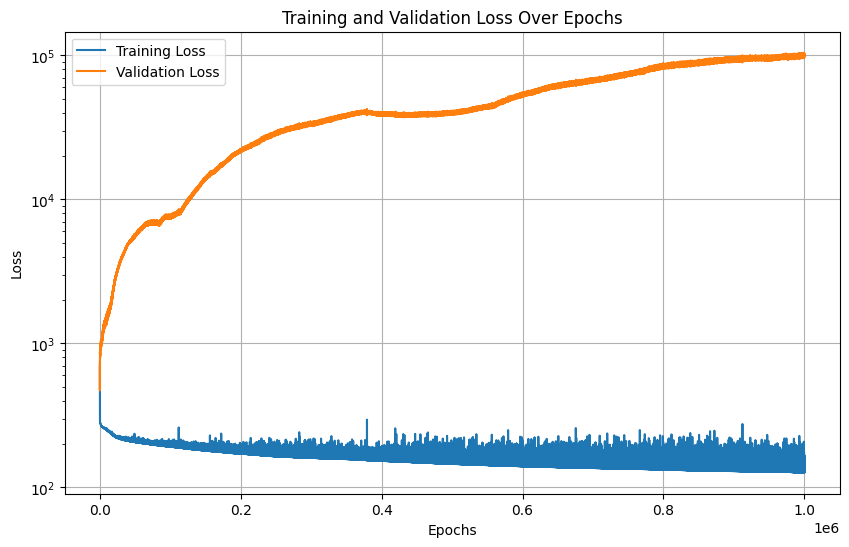

In [8]:
# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), results["training_losses"], label='Training Loss')
plt.plot(range(epochs), results["validation_losses"], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.savefig(os.path.join(task_results_dir, f'pp_mlp_loss_{suffix}.png'))

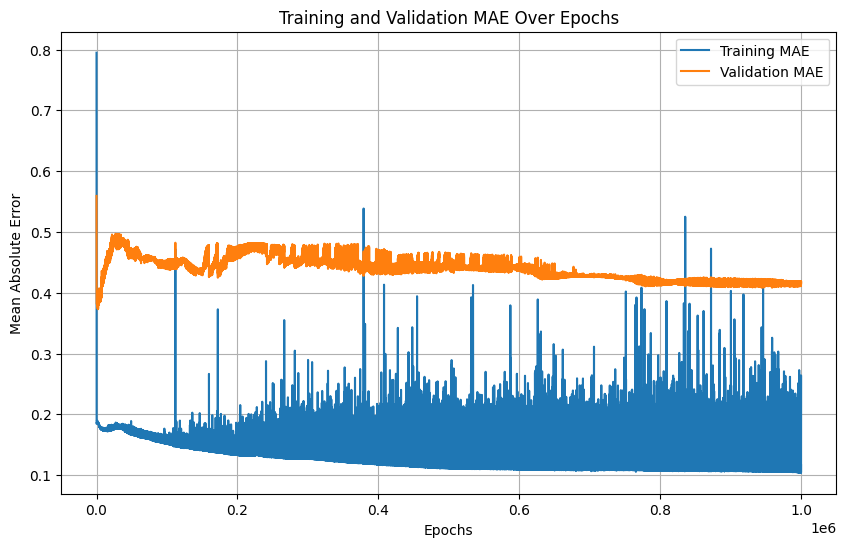

In [9]:
# Plot the training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), results["training_acc"], label='Training MAE')
plt.plot(range(epochs), results["validation_acc"], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
# plt.ylim(0.8, 1.0)
plt.title('Training and Validation MAE Over Epochs')
plt.legend()
plt.grid()
plt.savefig(os.path.join(task_results_dir, f'pp_mlp_acc_{suffix}.png'))

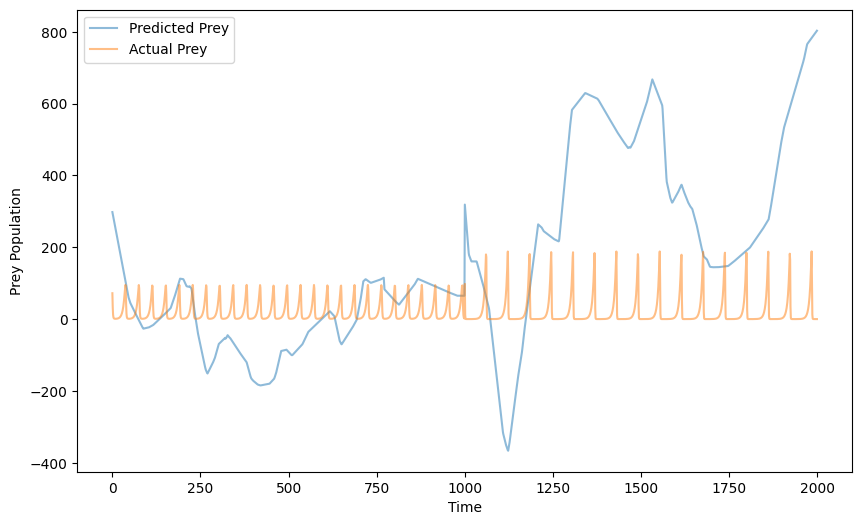

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(range(test_outputs.shape[0]), test_outputs[:,0], label="Predicted Prey", alpha=0.5)
plt.plot(range(test_outputs.shape[0]), testing_data['labels'][:,0], label="Actual Prey", alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Prey Population')
plt.legend()
plt.savefig(os.path.join(task_results_dir, f'pp_mlp_prey_{suffix}.png'))

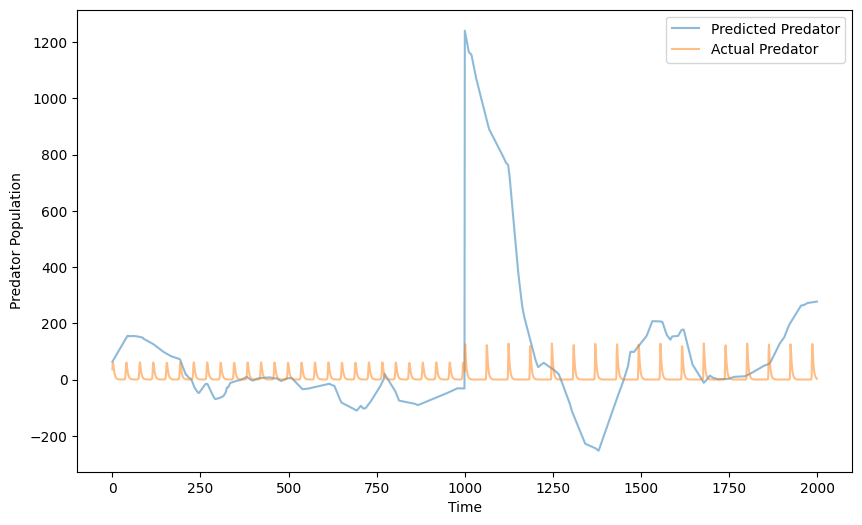

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(range(test_outputs.shape[0]), test_outputs[:,1], label="Predicted Predator", alpha=0.5)
plt.plot(range(test_outputs.shape[0]), testing_data['labels'][:,1], label="Actual Predator", alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Predator Population')
plt.legend()
plt.savefig(os.path.join(task_results_dir, f'pp_mlp_predator_{suffix}.png'))